In [18]:
import numpy as np
import pandas as pd
import time
import tracemalloc
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from functools import wraps

In [19]:
def make_tridiag_A1(n, dtype, k=6, m=4):
    d = np.full(n, k, dtype=dtype)
    u = np.zeros(n-1, dtype=dtype)
    l = np.zeros(n-1, dtype=dtype)
    for i in range(n):
        if i < n-1:
            u[i] = 1.0 / ((i+1) + m)
        if i > 0:
            l[i-1] = k / ((i+1) + m + 1)
    return l, d, u

def make_A1_full(n, dtype, k=6, m=4):
    l, d, u = make_tridiag_A1(n, dtype, k, m)
    A = np.diag(d) + np.diag(u,1) + np.diag(l,-1)
    return A



In [20]:
times = {'thomas': {}, 'gauss': {}}
mems  = {'thomas': {}, 'gauss': {}}

def timed_thomas(fn):
    @wraps(fn)
    def inner(l, d, u, b, dtype):
        tracemalloc.start()
        t0 = time.perf_counter()
        x = fn(l.astype(dtype), d.astype(dtype), u.astype(dtype), b.astype(dtype), dtype)
        dt = time.perf_counter() - t0
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        n = d.size
        times['thomas'][n] = dt
        mems ['thomas'][n] = peak
        return x
    return inner

@timed_thomas
def thomas_solver(l, d, u, b, dtype):
    n = d.size
    cp = np.empty(n-1, dtype=dtype)
    dp = np.empty(n,   dtype=dtype)
    cp[0] = u[0] / d[0]
    dp[0] = b[0] / d[0]
    for i in range(1, n):
        denom = d[i] - l[i-1]*cp[i-1]
        if i < n-1:
            cp[i] = u[i] / denom
        dp[i]    = (b[i] - l[i-1]*dp[i-1]) / denom
    x = np.empty(n, dtype=dtype)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i]*x[i+1]
    return x

def timed_gauss(fn):
    @wraps(fn)
    def inner(A, b, dtype):
        tracemalloc.start()
        t0 = time.perf_counter()
        x = fn(A.astype(dtype), b.astype(dtype), dtype)
        dt = time.perf_counter() - t0
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        n = A.shape[0]
        times['gauss'][n] = dt
        mems ['gauss'][n] = peak
        return x
    return inner

@timed_gauss
def gauss_elim(A, b, dtype):
    n = A.shape[0]
    AB = np.hstack((A.copy(), b.reshape(-1,1)))
    for i in range(n):
        maxr = np.argmax(np.abs(AB[i:, i])) + i
        if AB[maxr, i] == 0:
            raise np.linalg.LinAlgError("Zero pivot")
        if maxr != i:
            AB[[i, maxr]] = AB[[maxr, i]]
        AB[i] = AB[i] / AB[i, i]
        for j in range(i+1, n):
            AB[j] -= AB[j, i] * AB[i]

    U     = AB[:, :-1]
    b_aug = AB[:,  -1]
    x = np.zeros(n, dtype=dtype)
    for i in range(n-1, -1, -1):
        x[i] = b_aug[i] - np.dot(U[i, i+1:], x[i+1:])
    return x

In [21]:
def run_comparison(ns):
    records = []
    for n in ns:
        for dtype in (np.float32, np.float64):
            # 1) Thomas
            l, d, u = make_tridiag_A1(n, dtype)
            x_true = np.random.choice([1., -1.], size=n).astype(dtype)
            b_tri   = (np.diag(d) + np.diag(u,1) + np.diag(l,-1)) @ x_true
            x_t = thomas_solver(l, d, u, b_tri, dtype)
            err_inf_t = norm(x_true - x_t, ord=np.inf)
            err2_t    = norm(x_true - x_t, ord=2)
            cond_t    = norm(np.diag(d)+np.diag(u,1)+np.diag(l,-1), np.inf) * \
                        norm(inv(np.diag(d)+np.diag(u,1)+np.diag(l,-1)), np.inf)
            t_t, m_t  = times['thomas'][n], mems['thomas'][n]

            # 2) Gauss
            A_full = make_A1_full(n, dtype)
            b_full = A_full @ x_true
            x_g = gauss_elim(A_full, b_full, dtype)
            err_inf_g = norm(x_true - x_g, ord=np.inf)
            err2_g    = norm(x_true - x_g, ord=2)
            cond_g    = norm(A_full, np.inf) * norm(inv(A_full), np.inf)
            t_g, m_g  = times['gauss'][n], mems['gauss'][n]

            records.append({
                'n':            n,
                'dtype':        dtype.__name__,
                'err_inf_thomas': err_inf_t,
                'err2_thomas':    err2_t,
                'time_thomas':    t_t,
                'mem_thomas':     m_t,
                'cond_thomas':    cond_t,
                'err_inf_gauss': err_inf_g,
                'err2_gauss':    err2_g,
                'time_gauss':    t_g,
                'mem_gauss':     m_g,
                'cond_gauss':    cond_g,
            })
    return pd.DataFrame.from_records(records)


In [31]:
title_map = {
    'time_thomas':   ('Czas Thomasa',           'sekundy'),
    'time_gauss':    ('Czas Gaussa',             'sekundy'),
    'mem_thomas':    ('Pam. Thomasa',           'bajty'),
    'mem_gauss':     ('Pam. Gaussa',             'bajty'),
    'err_inf_thomas':('Błąd maksymalny Thomasa',         '‖x_true–x_calc‖∞'),
    'err_inf_gauss': ('Błąd maksymalny Gaussa',           '‖x_true–x_calc‖∞'),
    'err2_thomas':   ('Błąd euklidesowy Thomasa',         '‖x_true–x_calc‖₂'),
    'err2_gauss':    ('Błąd euklidesowy Gaussa',           '‖x_true–x_calc‖₂'),
    'cond_thomas':   ('Współcz. uwarunkowania Thomasa', 'Cond(A_tri) = ‖A_tri‖∞·‖A_tri⁻¹‖∞'),
    'cond_gauss':    ('Współcz. uwarunkowania Gaussa',   'Cond(A_full) = ‖A_full‖∞·‖A_full⁻¹‖∞'),
}

def plot_with_range(df, metric, scale, n_min, n_max):
    sub = df[(df['n']>=n_min)&(df['n']<=n_max)]
    plt.figure(figsize=(9,5))
    for dtype in ('float32','float64'):
        plt.scatter(
            sub['n'],
            sub[f"{metric}"].where(sub['dtype']==dtype),
            s=8,
            label=dtype
        )
    if scale=='log': plt.yscale('log')
    title, ylabel = title_map[metric]
    plt.title(f"{title} ({'logarytmiczna' if scale=='log' else 'liniowa'}) dla n={n_min}…{n_max}")
    plt.xlabel('n')
    plt.ylabel(ylabel)
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()



In [ ]:
def plot_comparison_all(df, scale='linear', n_min=2, n_max=1000):
    metrics = [
        ("Czas obliczeń [s]",       "time"),
        ("Błąd maksymalny: ‖x_true–x_calc‖∞",  "err_inf"),
        ("Błąd euklidesowy: ‖x_true–x_calc‖₂",  "err2"),
        ("Zajętość pamięci [bajty]", "mem"),
    ]

    specs = [
        ("gauss",  "float32", "o", "gauss32"),
        ("thomas", "float32", "x", "thomas32"),
        ("gauss",  "float64", "s", "gauss64"),
        ("thomas", "float64", "D", "thomas64"),
    ]

    sub = df[(df['n'] >= n_min) & (df['n'] <= n_max)]
    for ylabel, prefix in metrics:
        plt.figure(figsize=(9,5))
        for alg, dtype, marker, label in specs:
            col = f"{prefix}_{alg}"
            sel = sub[sub['dtype'] == dtype]
            plt.scatter(
                sel['n'],
                sel[col],
                marker=marker,
                s=6,
                label=label
            )

        if scale == 'log':
            plt.yscale('log')

        plt.title(f"{ylabel} – skala {'logarytmiczna' if scale=='log' else 'liniowa'} (n={n_min}…{n_max})")
        plt.xlabel("n")
        plt.ylabel(ylabel)
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.tight_layout()
        plt.show()

In [ ]:
if __name__ == '__main__':
    np.random.seed(0)
    ns = list(range(2, 101)) + list(range(110, 1001, 10))  # n=2..100, n=110..1000 co 10
    df = run_comparison(ns)
    df.to_csv('comparison_results.csv', index=False)

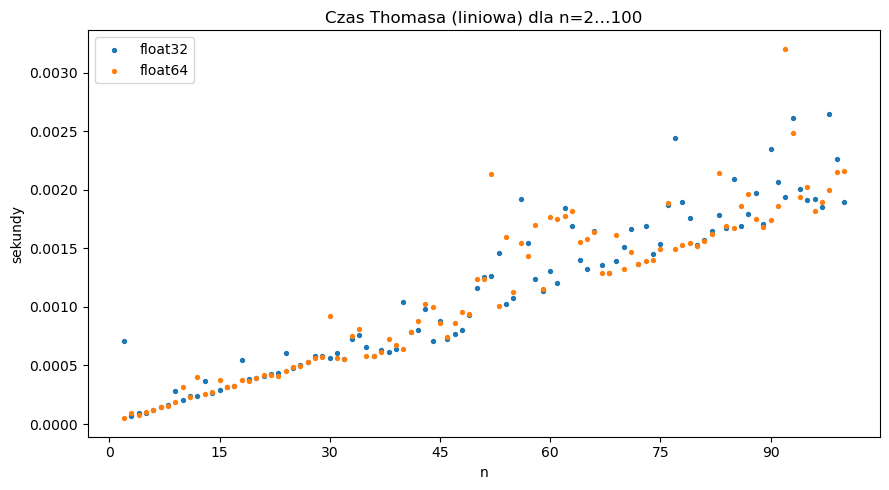

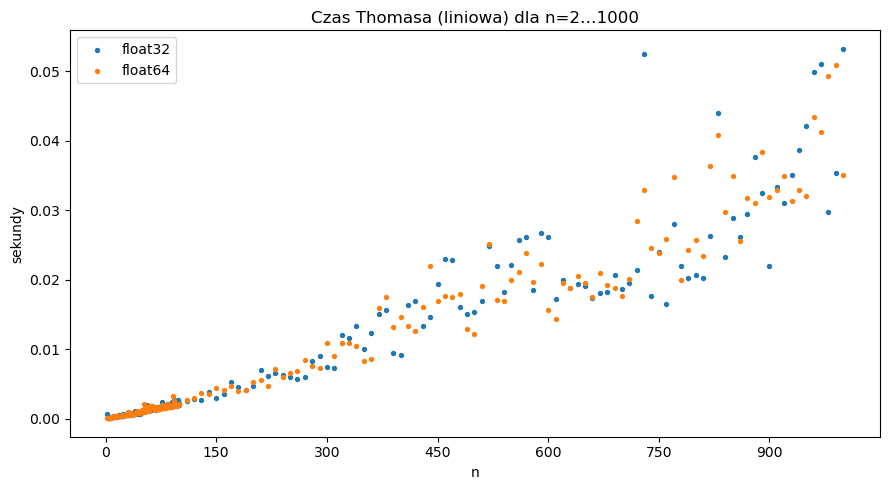

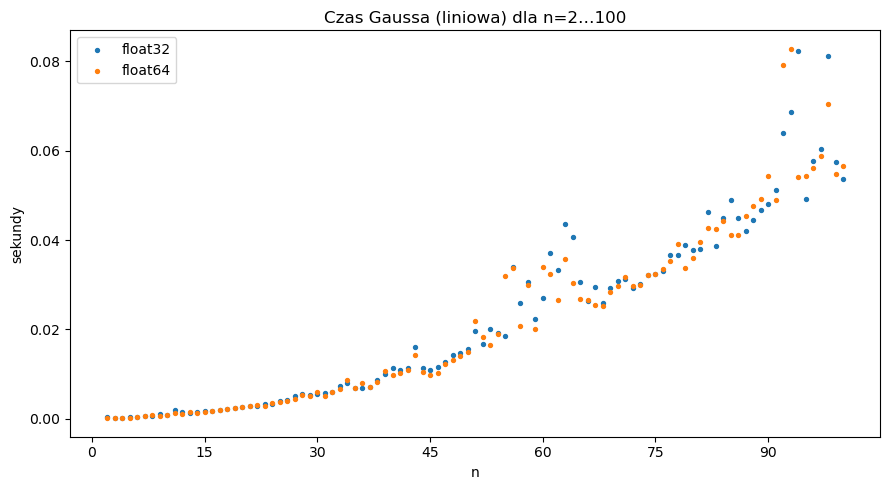

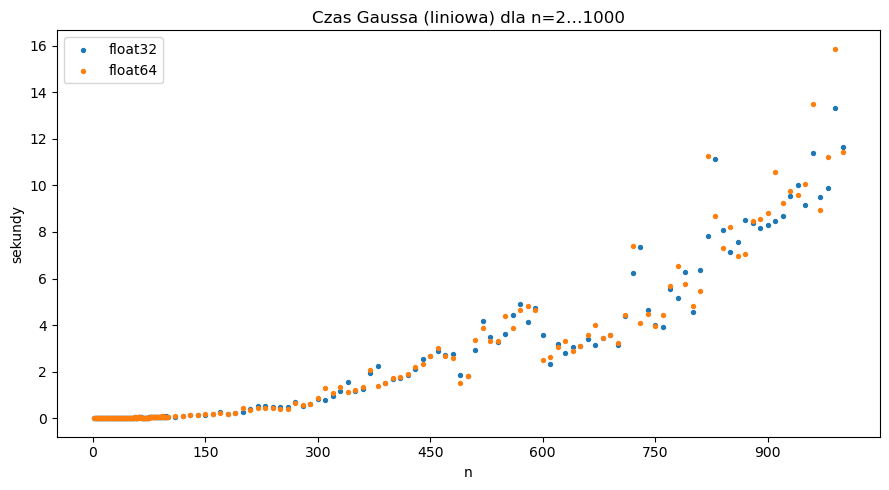

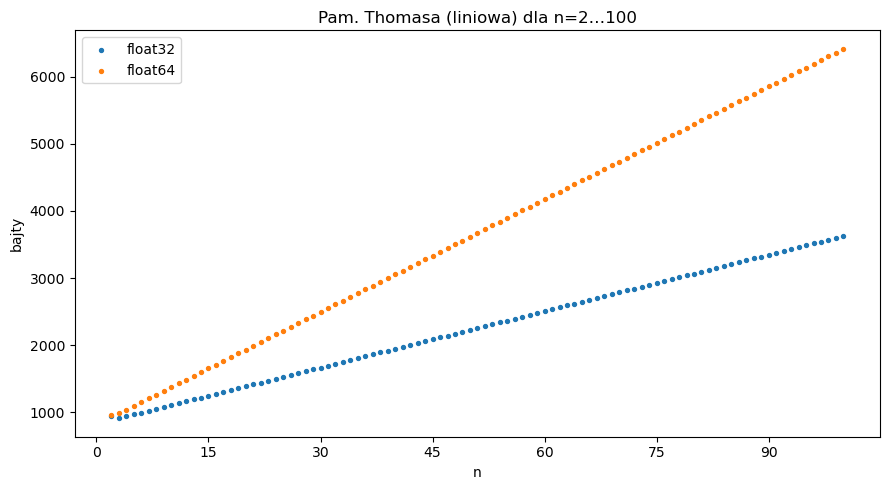

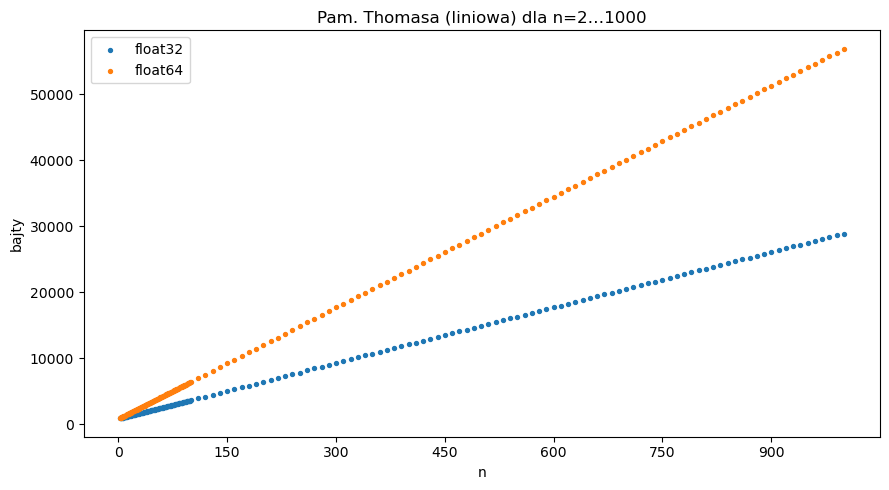

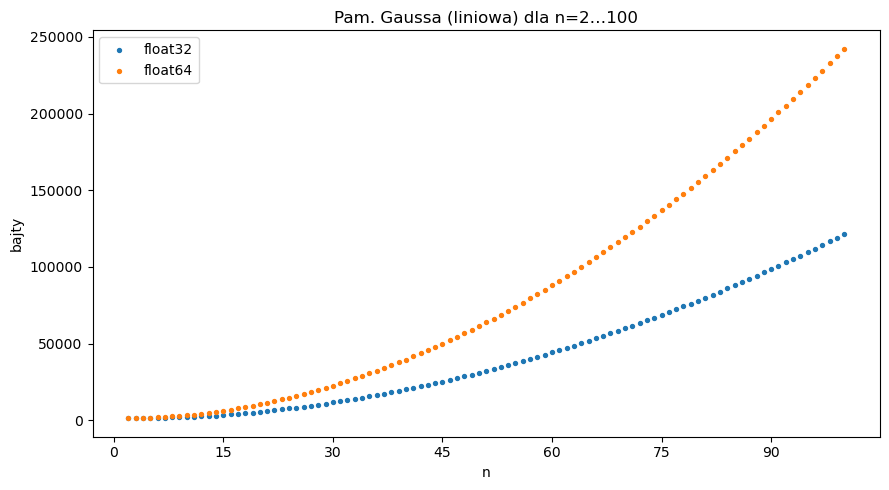

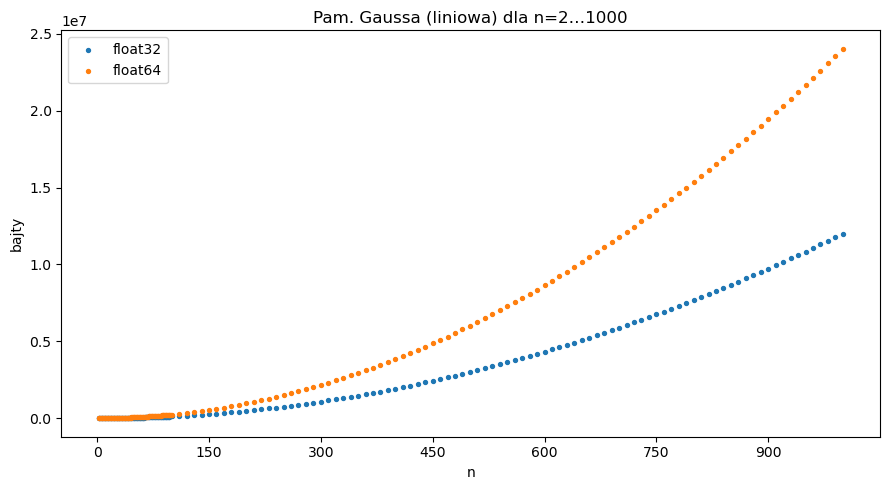

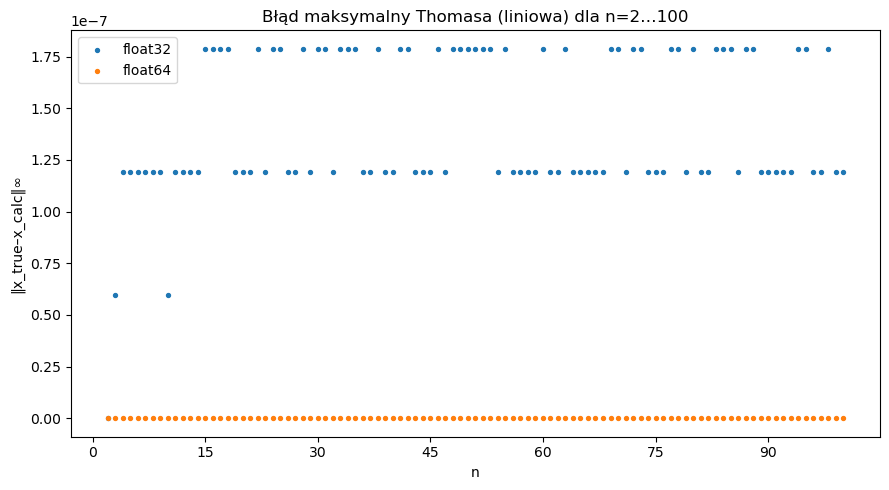

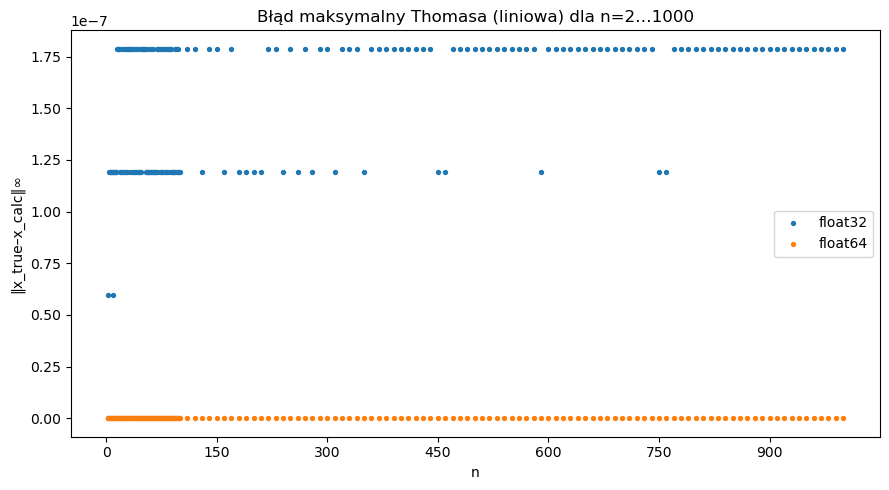

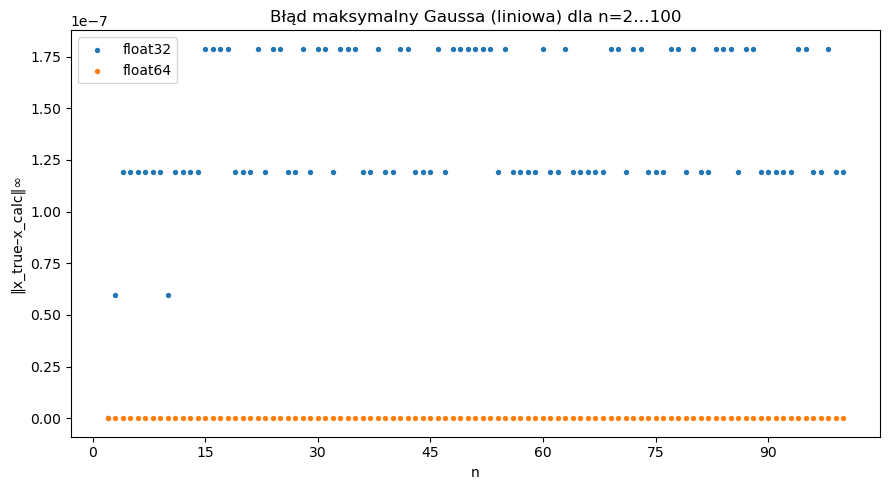

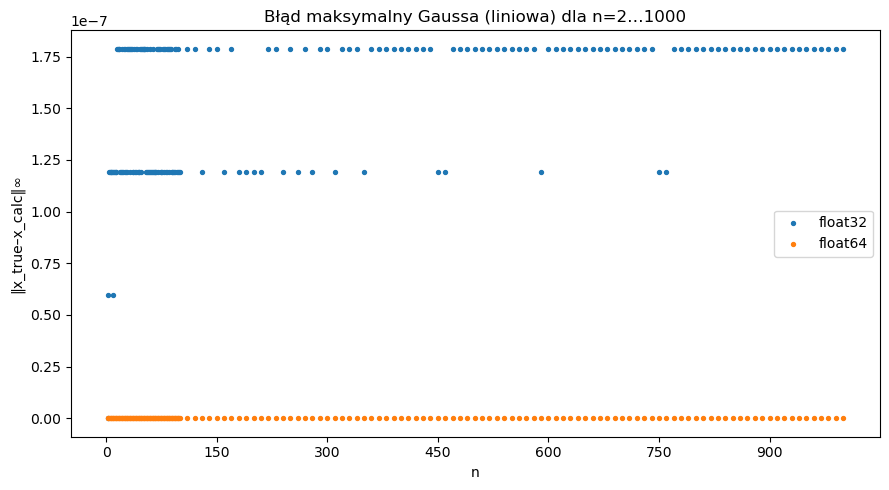

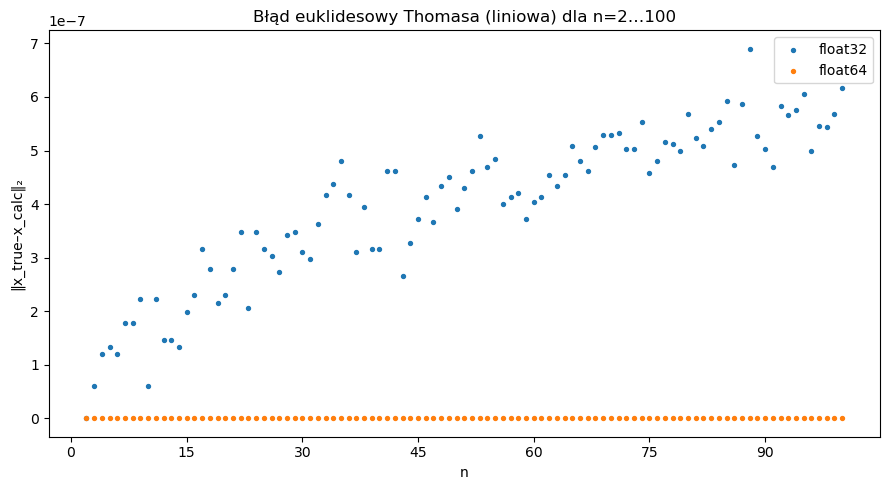

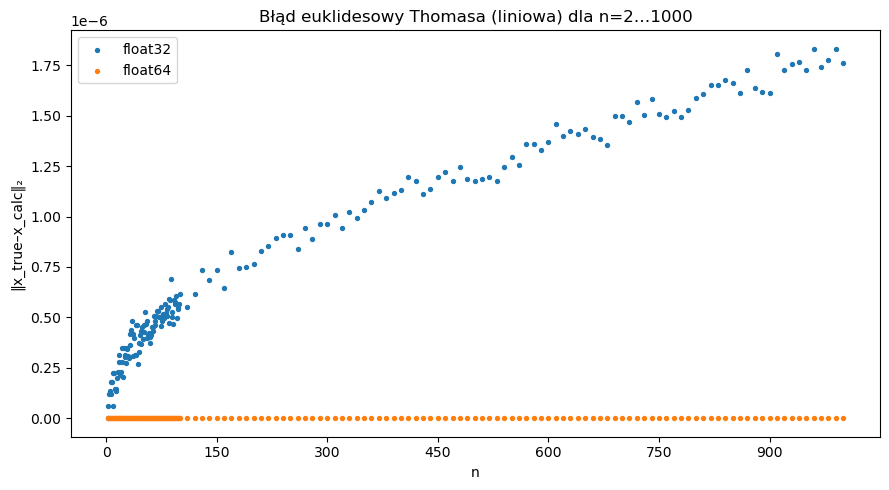

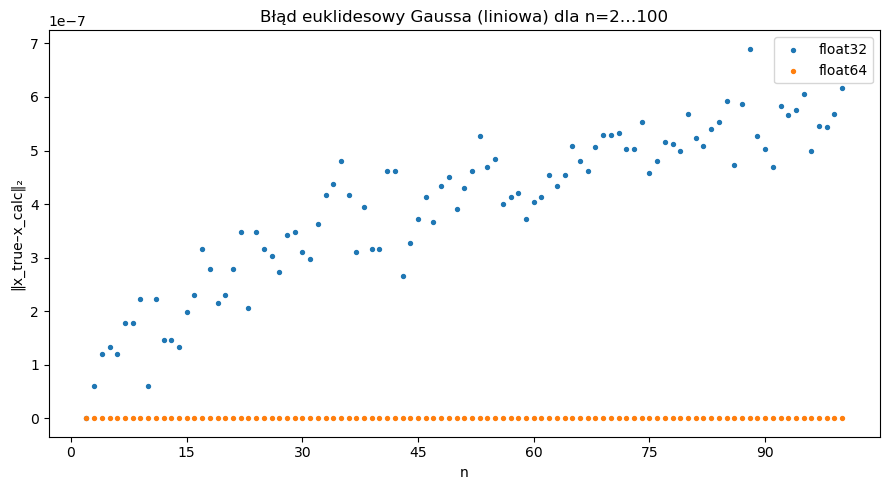

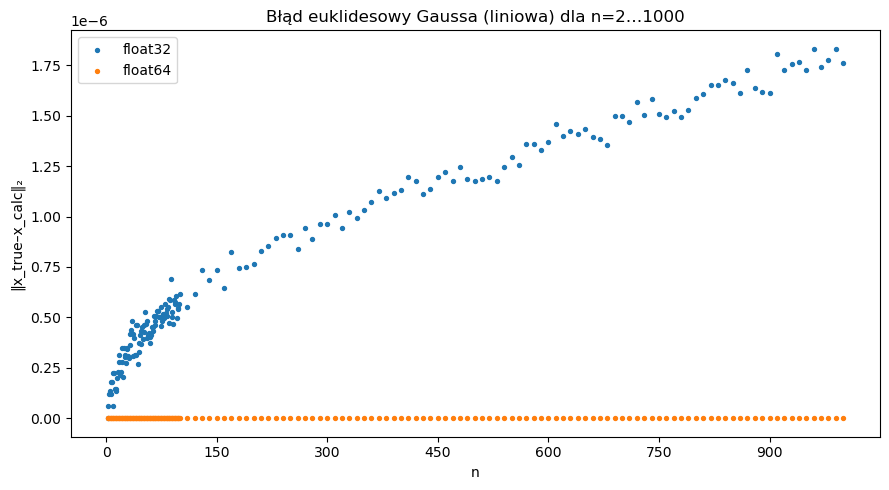

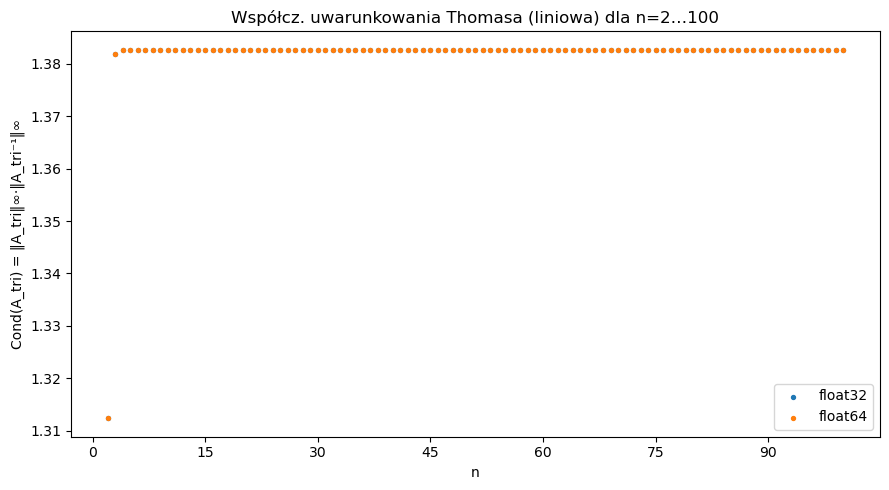

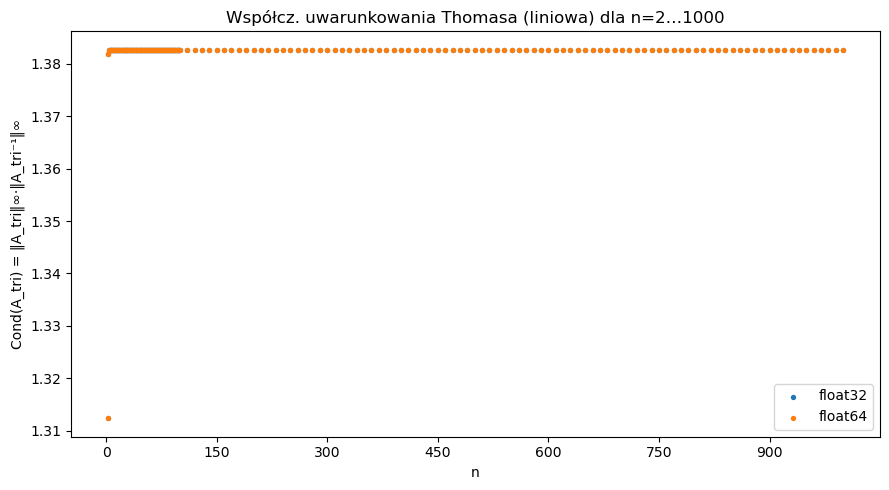

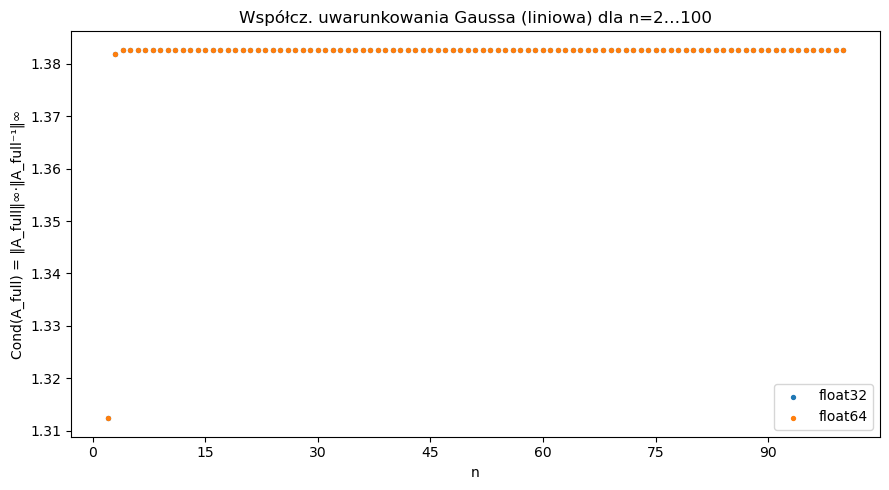

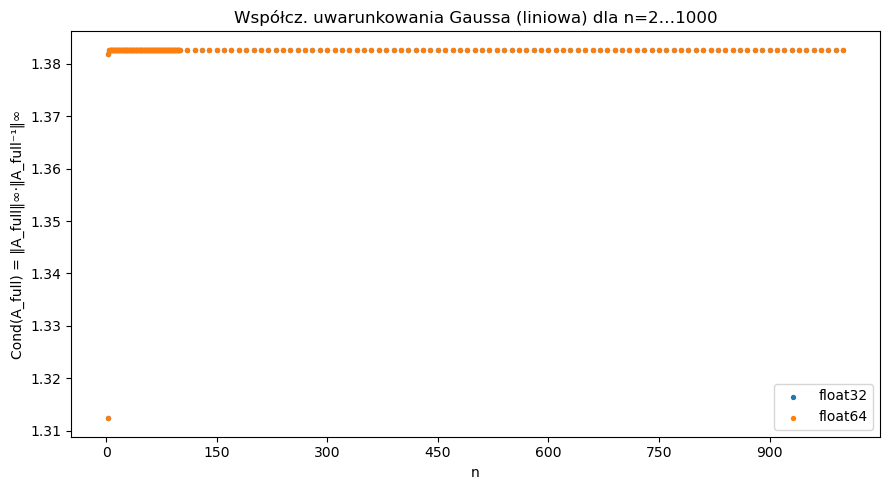

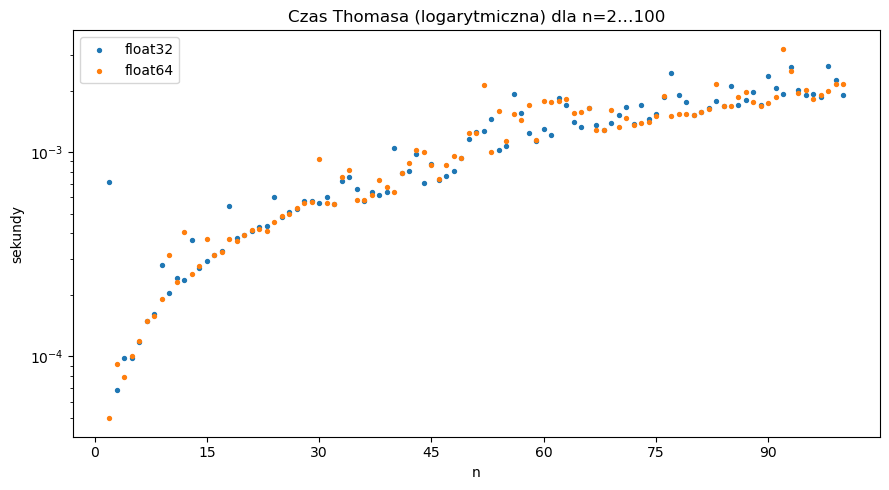

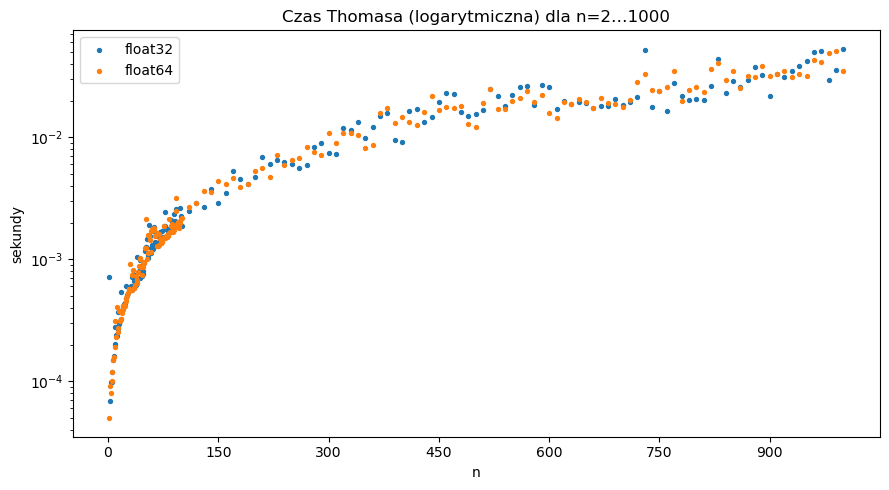

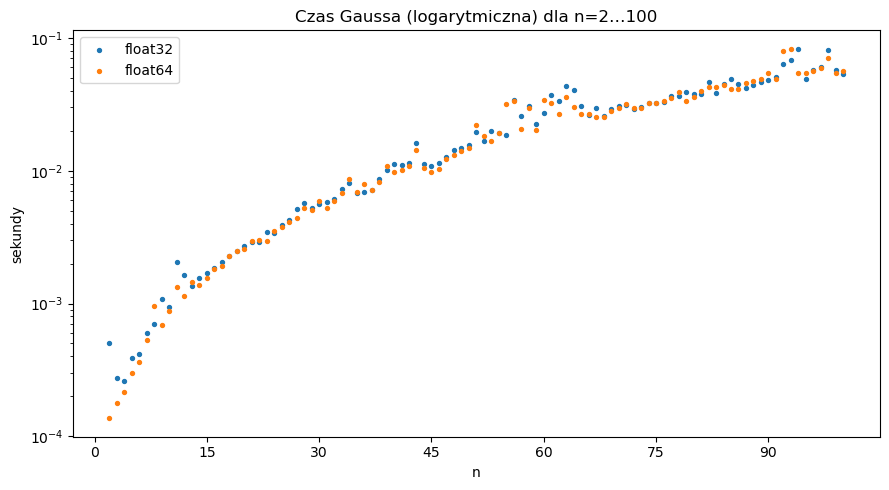

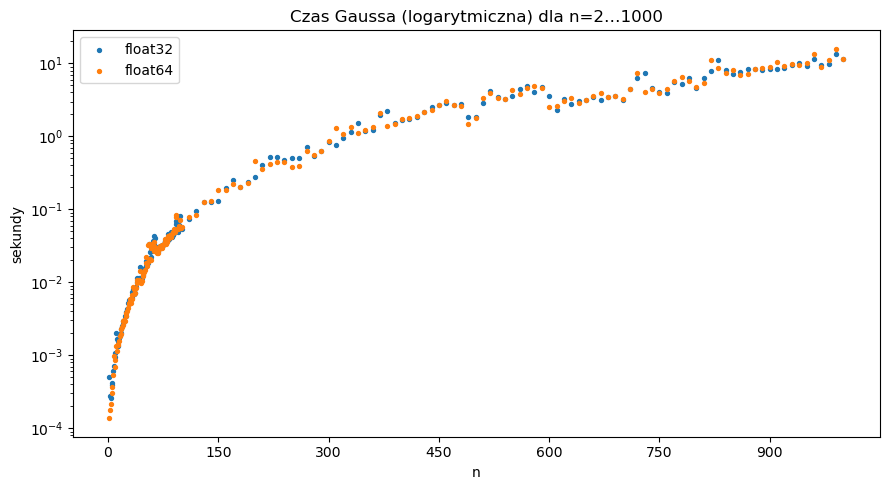

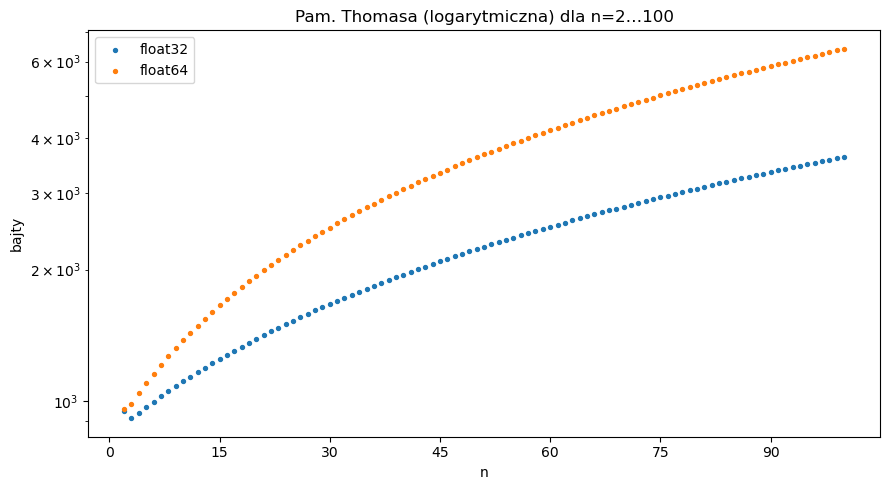

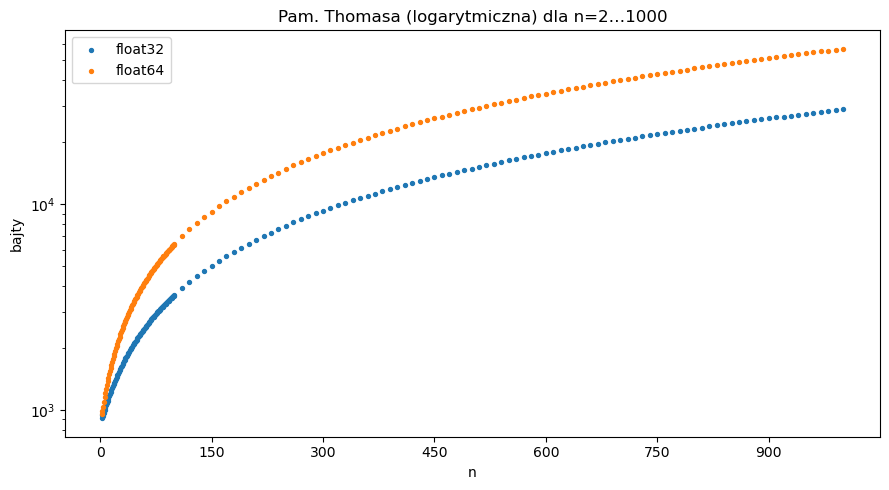

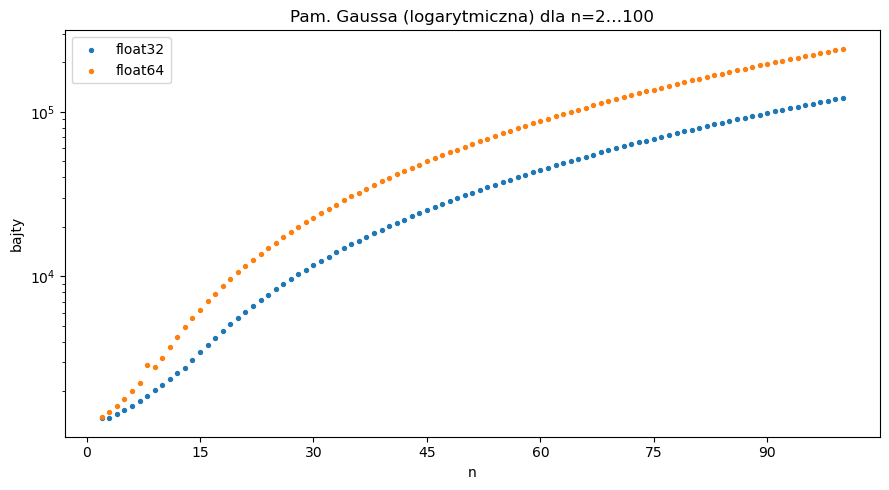

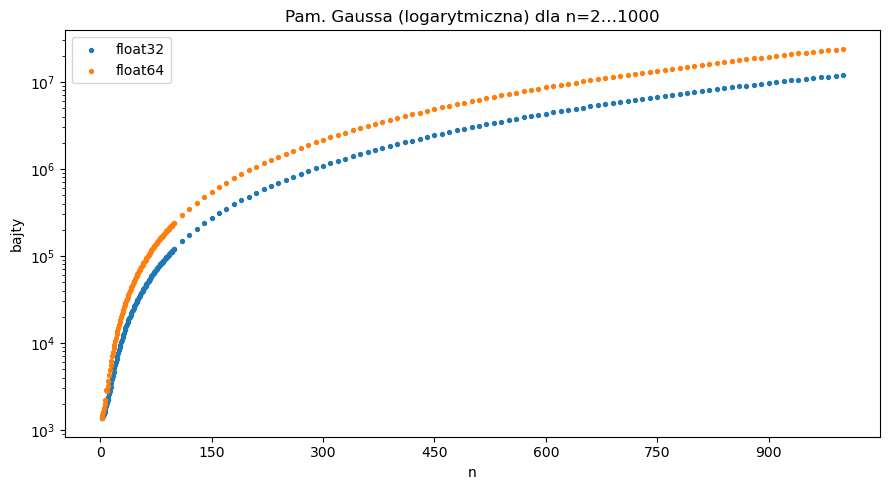

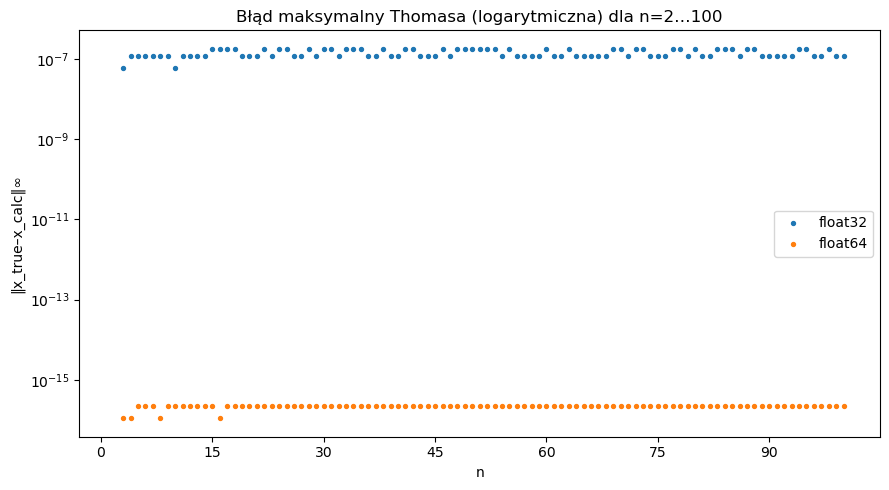

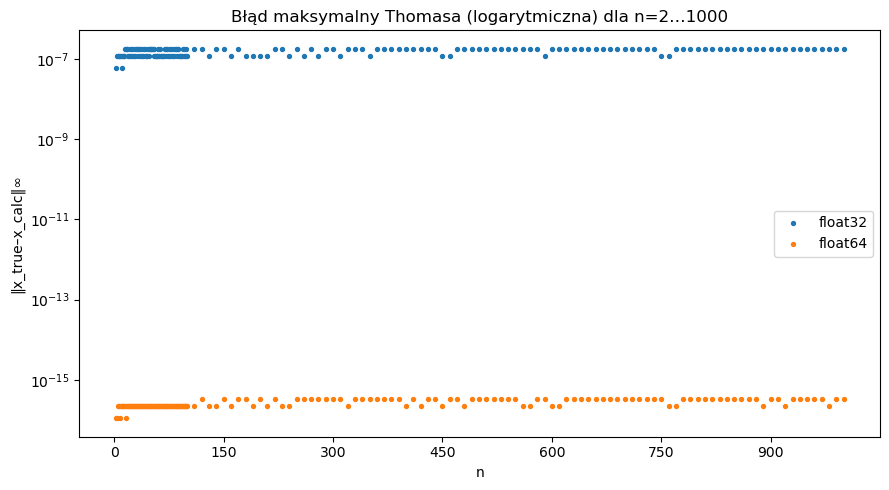

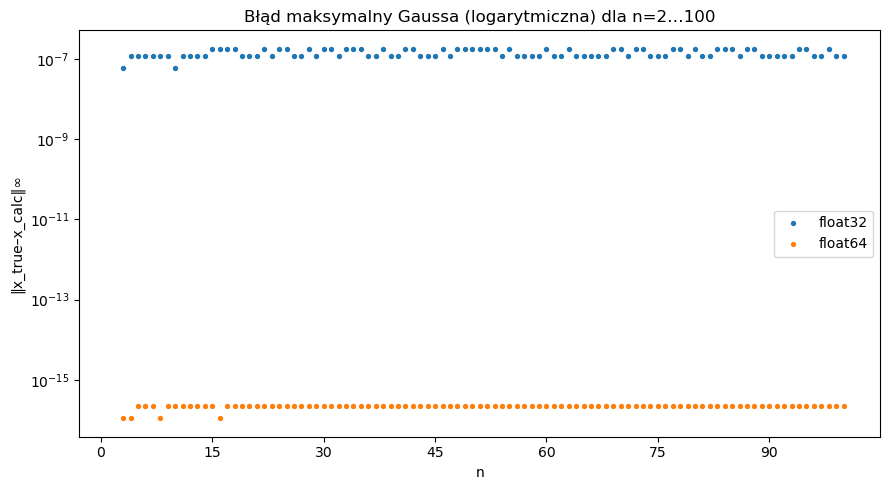

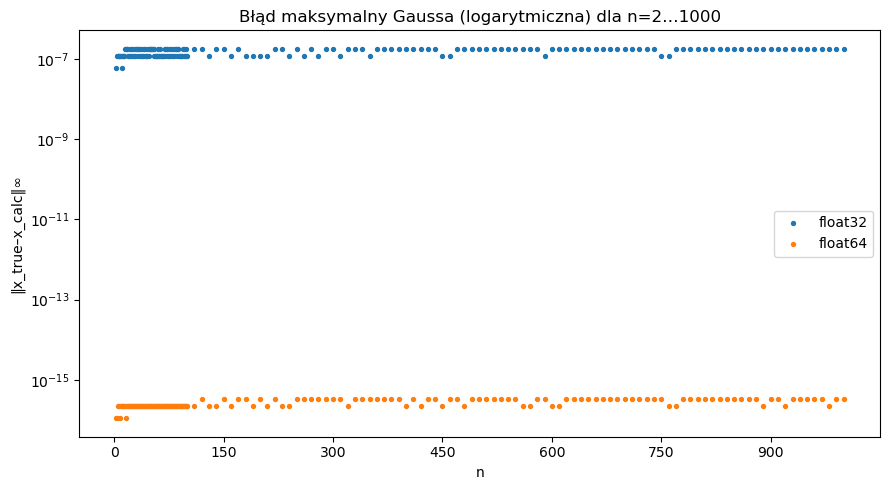

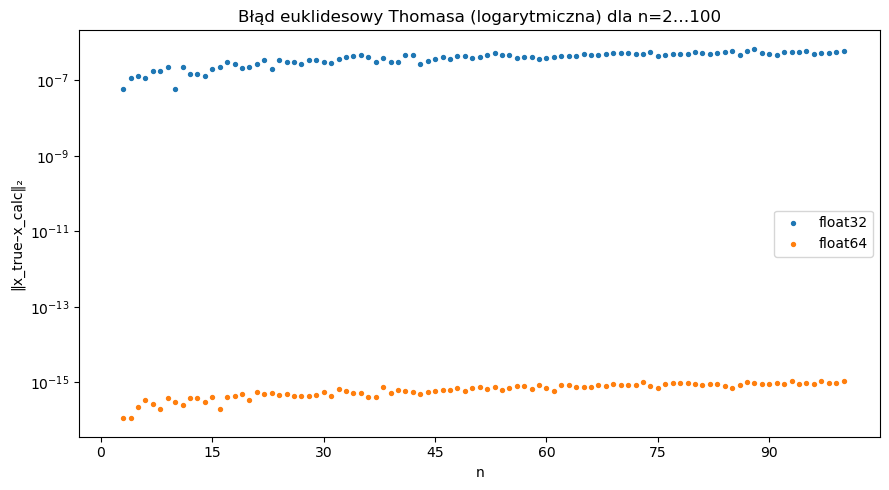

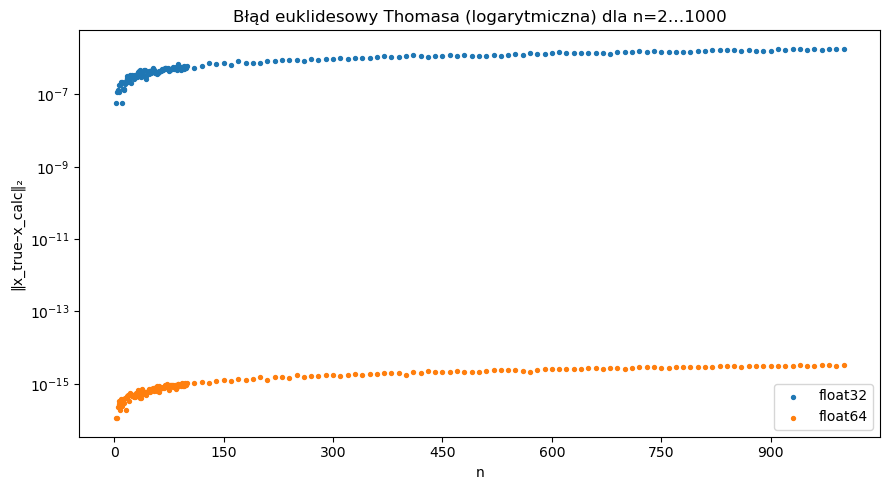

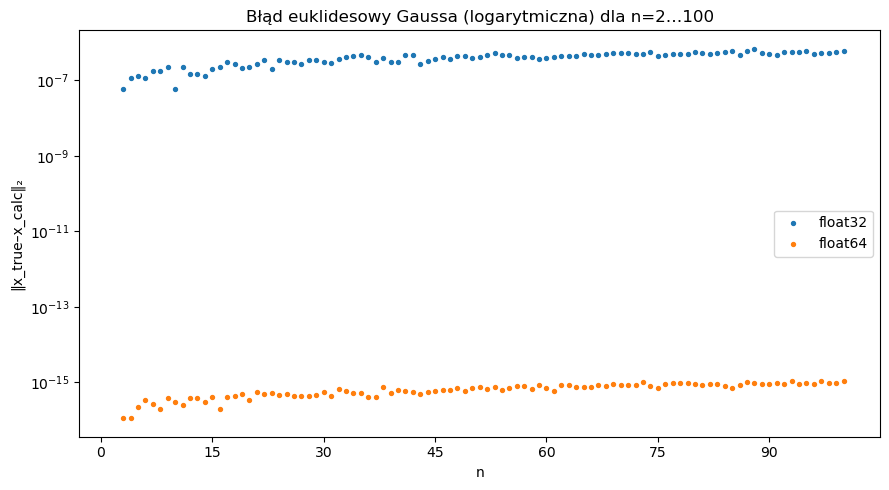

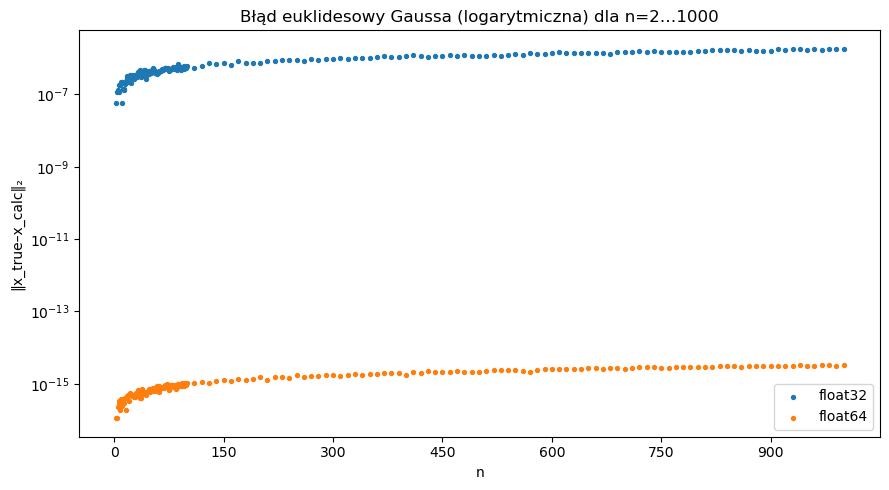

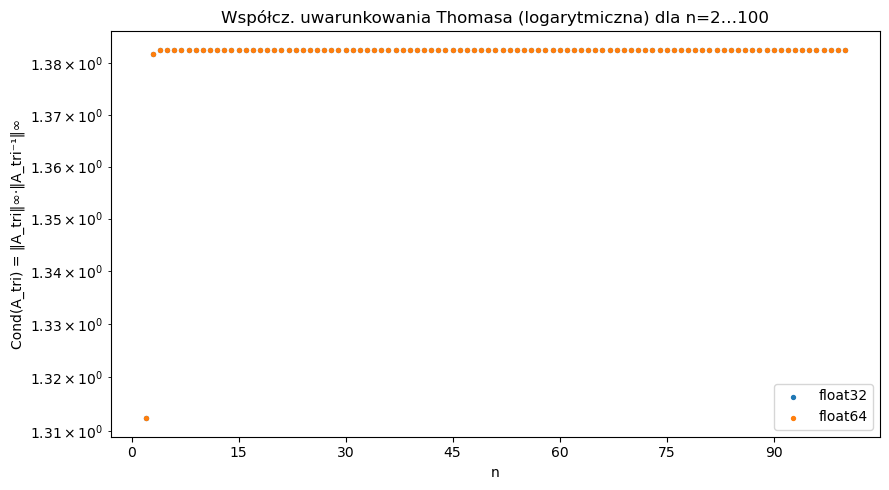

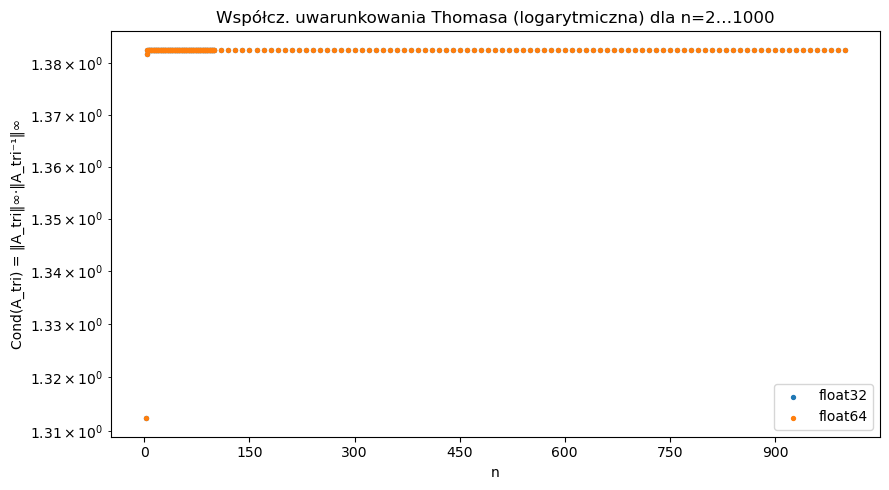

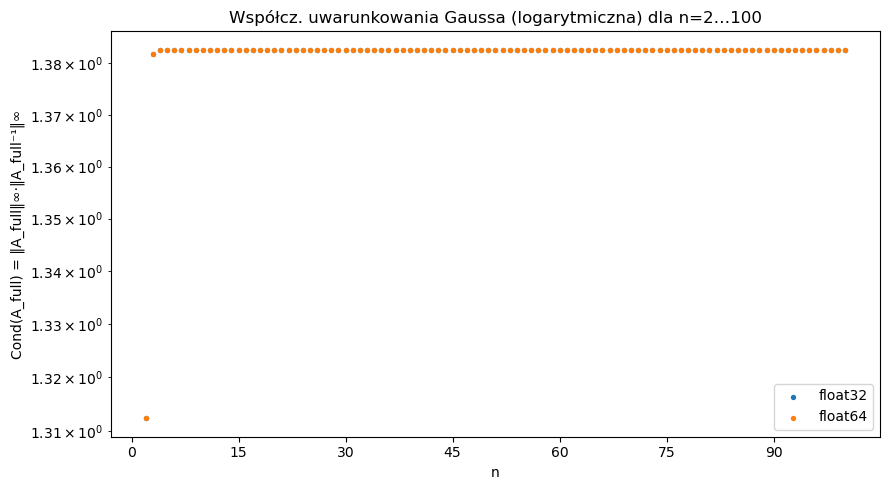

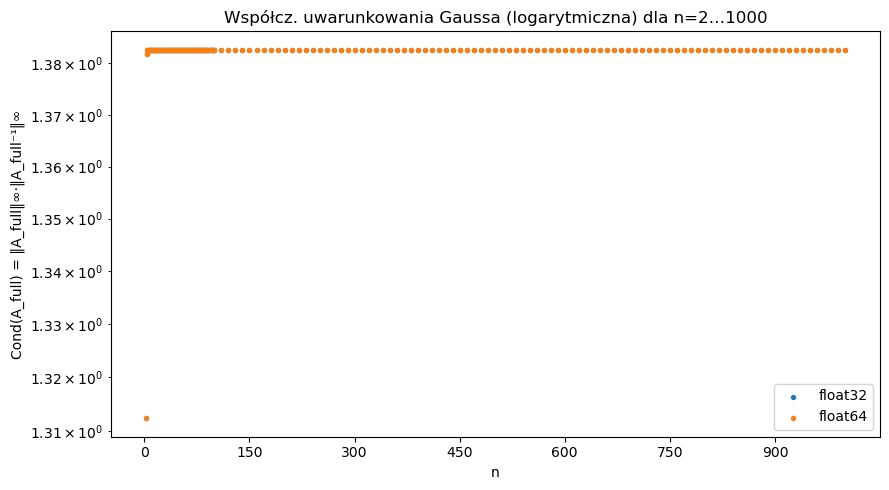

In [54]:
metrics = [
    'time_thomas','time_gauss',
    'mem_thomas','mem_gauss',
    'err_inf_thomas','err_inf_gauss',
    'err2_thomas','err2_gauss',
    'cond_thomas','cond_gauss',
]

for scale in ('linear','log'):
    for metric in metrics:
        plot_with_range(df, metric, scale=scale, n_min=2, n_max=100)
        plot_with_range(df, metric, scale=scale, n_min=2, n_max=1000)

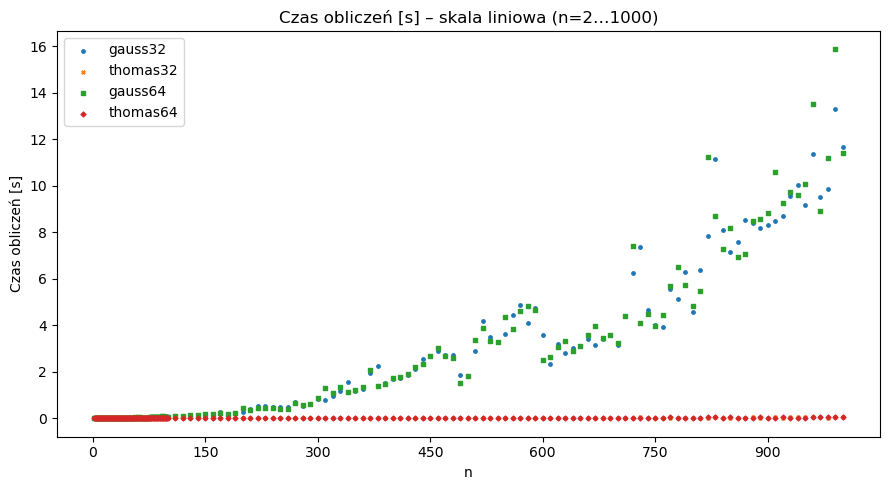

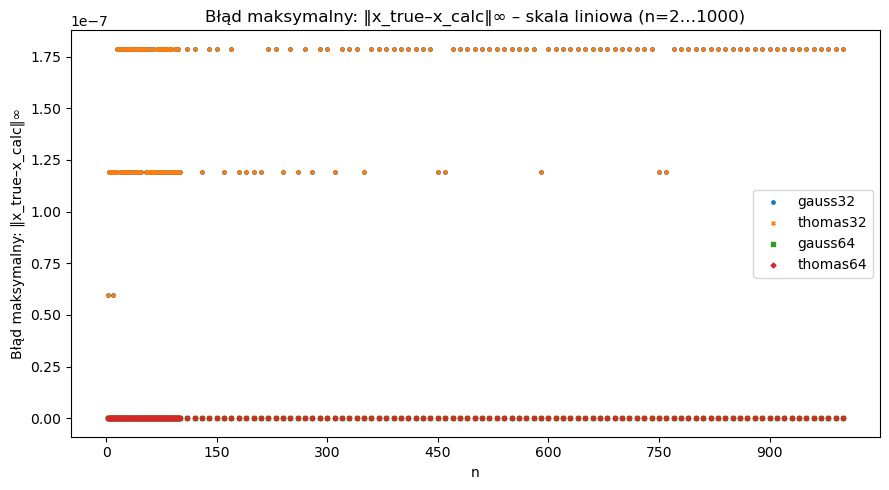

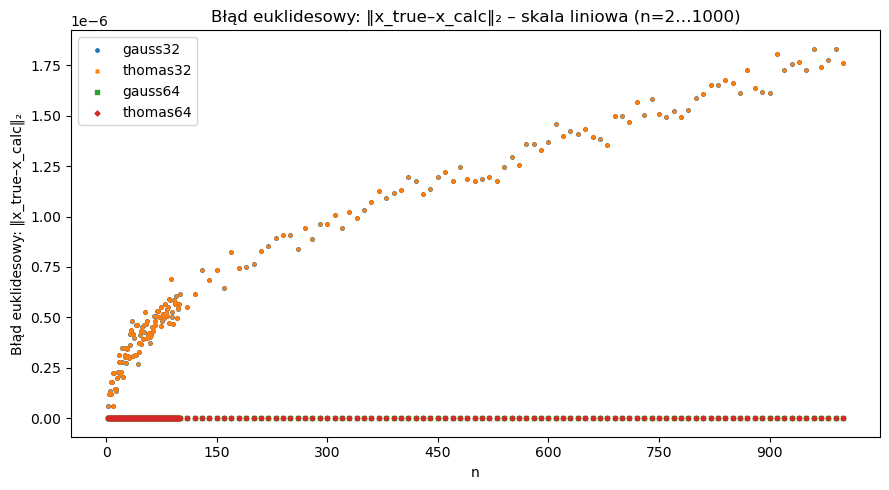

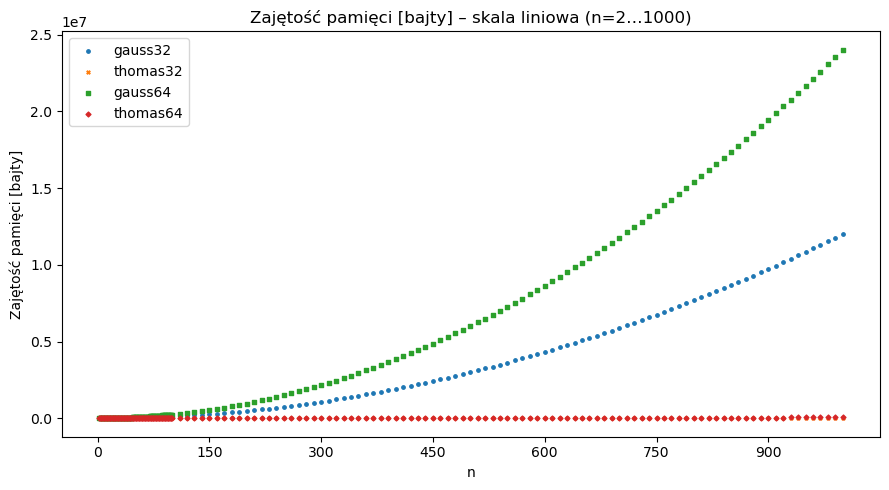

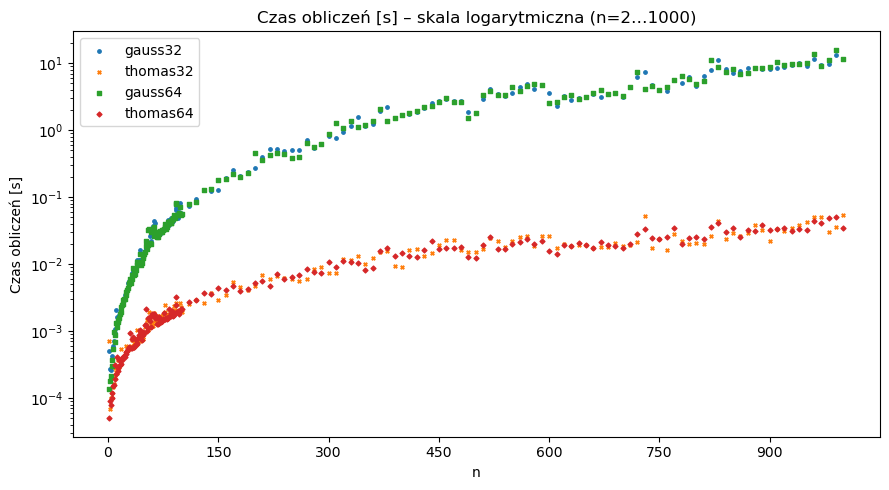

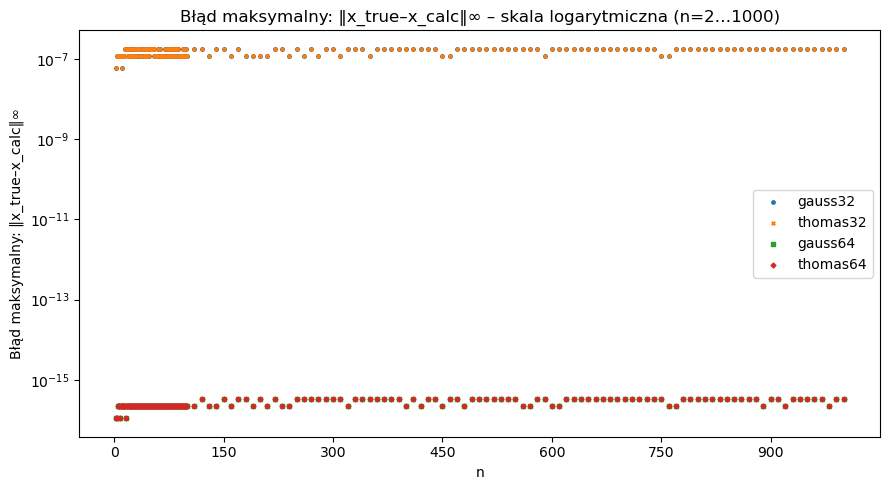

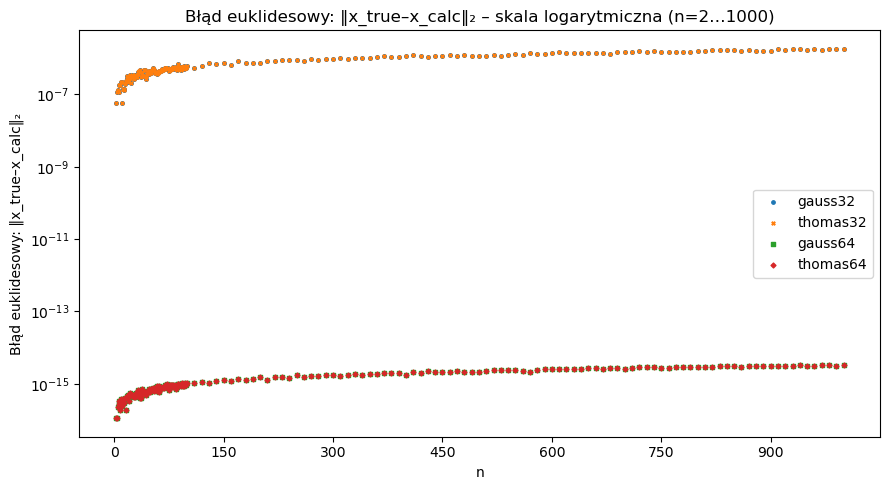

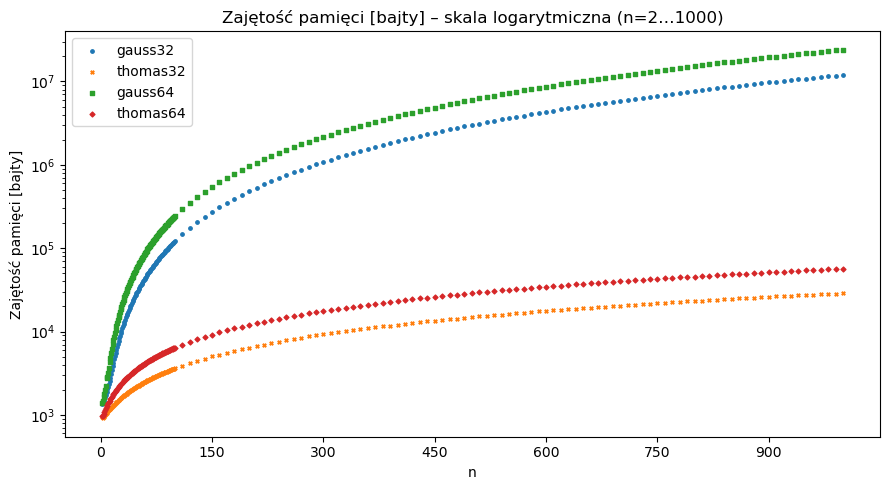

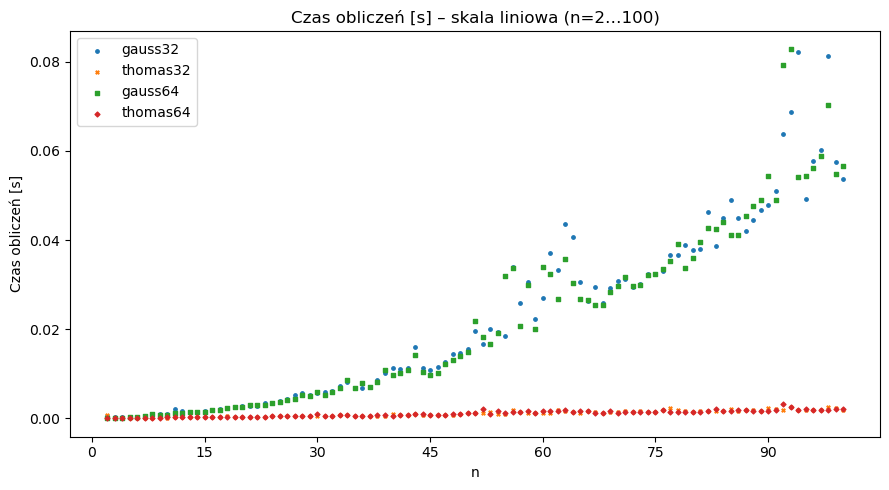

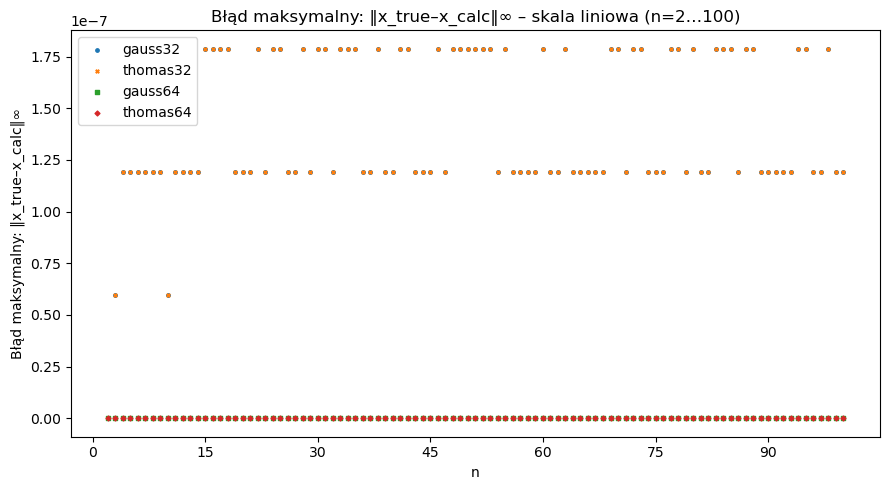

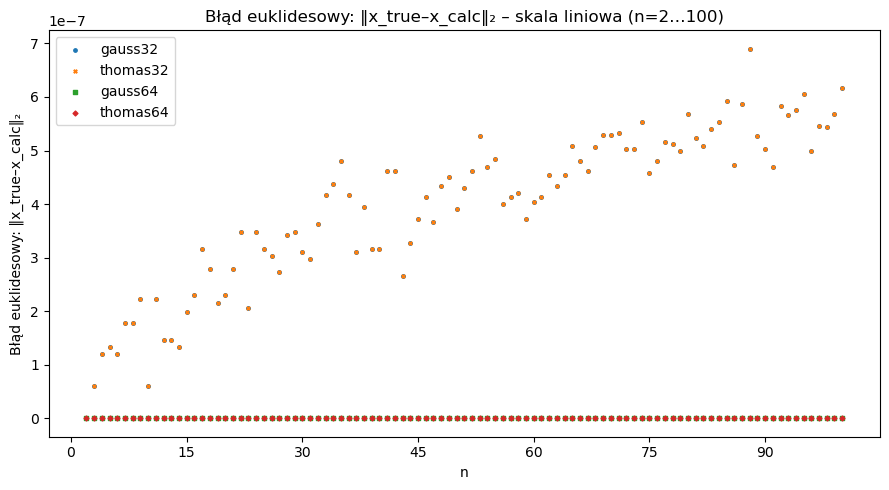

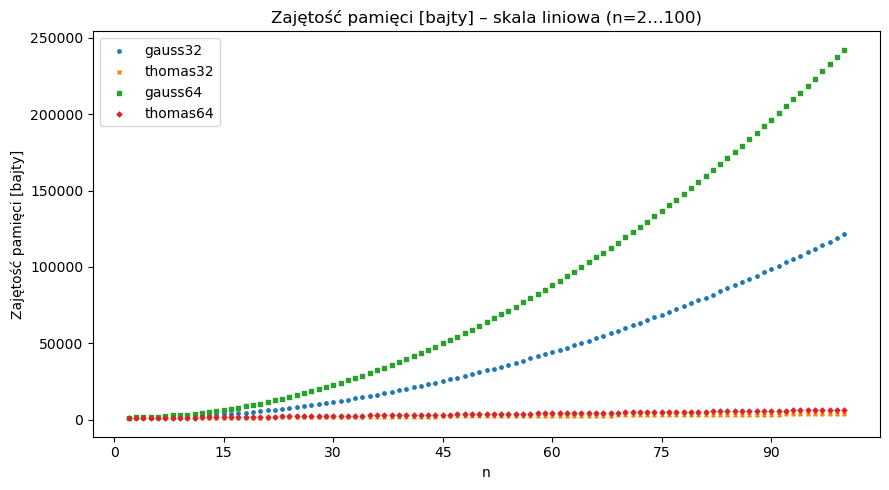

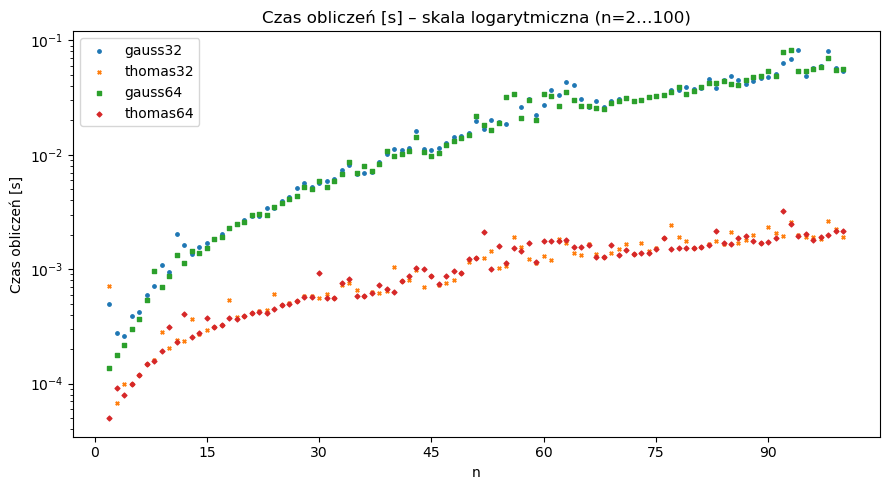

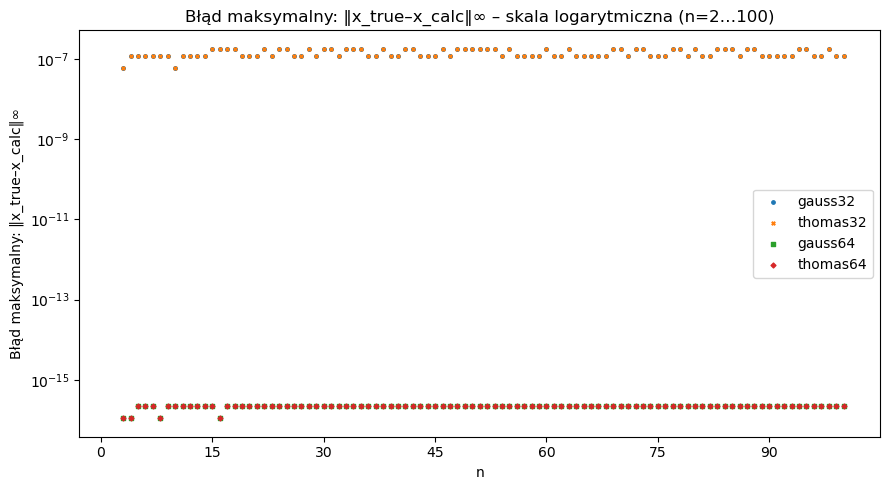

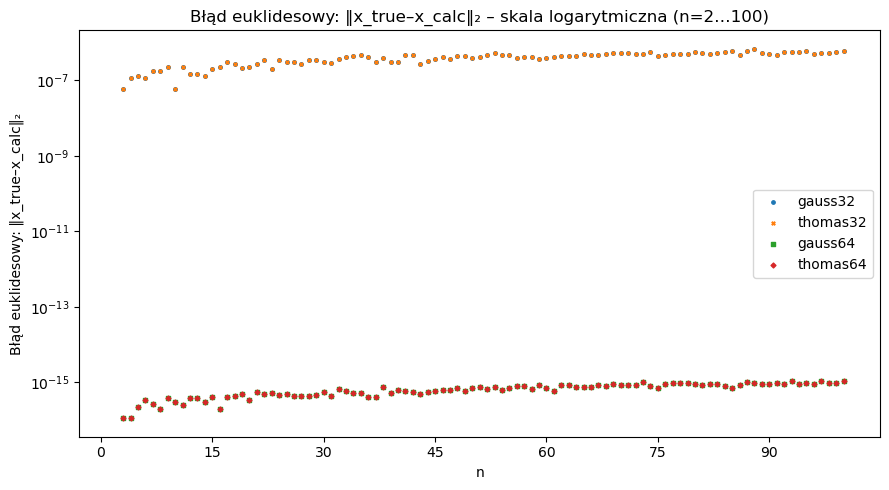

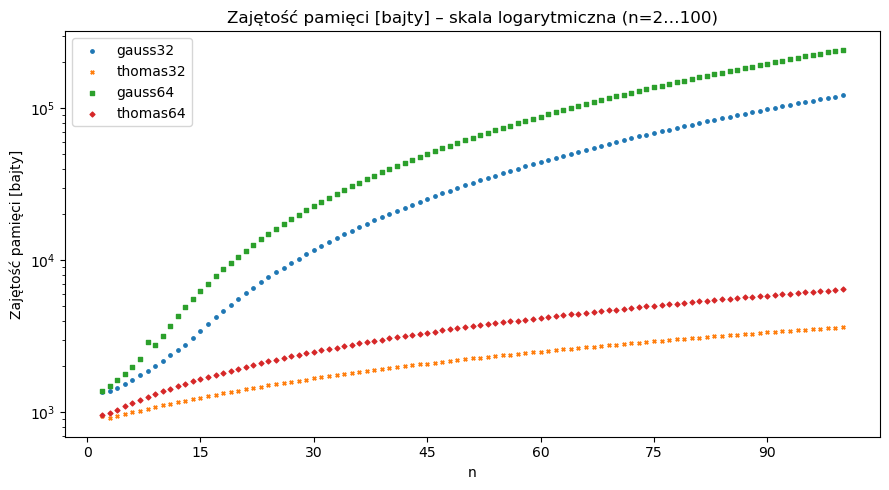

In [55]:
plot_comparison_all(df, scale='linear', n_min=2, n_max=1000)

plot_comparison_all(df, scale='log',    n_min=2, n_max=1000)

plot_comparison_all(df, scale='linear', n_min=2, n_max=100)

plot_comparison_all(df, scale='log',    n_min=2, n_max=100)